# Image Classification Using Logistic Regression in PyTorch with CIFAR-10 Data Set

In [1]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 3*32*32
num_classes = 10

## **Dataset and Data Loaders**

### Dataset

In [3]:
# Download dataset
dataset = CIFAR10(root='data/', train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [4]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
# Traiing valiadation & test dataset
train_ds, val_ds = random_split(dataset, [40000, 10000])
test_ds = CIFAR10(root='data/', train=False, transform=transforms.ToTensor())

In [7]:
print(train_ds)
print(test_ds)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()


### Data Loaders

In [8]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label:  1


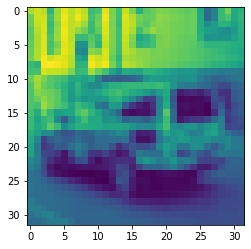

In [9]:
image, label = train_ds[0]
plt.imshow(image[0])
print('Label: ', label)

images.shape: torch.Size([128, 3, 32, 32])


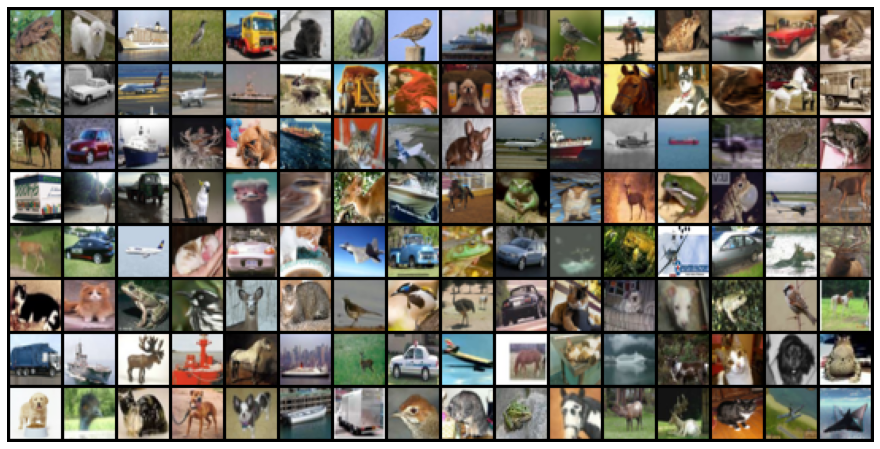

In [10]:
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## **Model**

In [11]:
class Cifar10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)#else xb.reshape(-1, 3*32*32)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = Cifar10Model()

## Training

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
evaluate(model, val_loader)

{'val_acc': 0.09833984076976776, 'val_loss': 2.3115317821502686}

In [15]:
history = fit(50, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 2.1398, val_acc: 0.2521
Epoch [1], val_loss: 2.0646, val_acc: 0.2749
Epoch [2], val_loss: 2.0171, val_acc: 0.3054
Epoch [3], val_loss: 1.9871, val_acc: 0.3136
Epoch [4], val_loss: 1.9615, val_acc: 0.3349
Epoch [5], val_loss: 1.9434, val_acc: 0.3382
Epoch [6], val_loss: 1.9281, val_acc: 0.3473
Epoch [7], val_loss: 1.9167, val_acc: 0.3479
Epoch [8], val_loss: 1.9044, val_acc: 0.3530
Epoch [9], val_loss: 1.8979, val_acc: 0.3551
Epoch [10], val_loss: 1.8885, val_acc: 0.3614
Epoch [11], val_loss: 1.8817, val_acc: 0.3634
Epoch [12], val_loss: 1.8745, val_acc: 0.3654
Epoch [13], val_loss: 1.8687, val_acc: 0.3668
Epoch [14], val_loss: 1.8644, val_acc: 0.3656
Epoch [15], val_loss: 1.8580, val_acc: 0.3704
Epoch [16], val_loss: 1.8551, val_acc: 0.3717
Epoch [17], val_loss: 1.8507, val_acc: 0.3714
Epoch [18], val_loss: 1.8473, val_acc: 0.3749
Epoch [19], val_loss: 1.8459, val_acc: 0.3691
Epoch [20], val_loss: 1.8404, val_acc: 0.3761
Epoch [21], val_loss: 1.8372, val_acc: 0.377

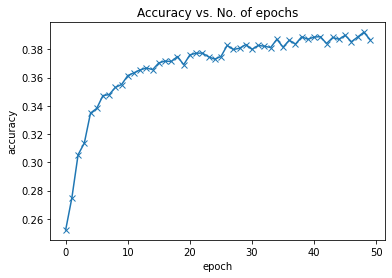

In [16]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [17]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.37744140625, 'val_loss': 1.7881996631622314}

## **Predictions**

In [18]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


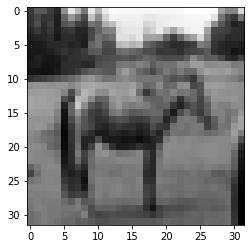

In [26]:
img, label = test_ds[10000-1]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [31]:
for i in range(10):
    img, label = test_ds[i]
    print(i,'Label:', label, ', Predicted:', predict_image(img, model))

0 Label: 3 , Predicted: 3
1 Label: 8 , Predicted: 9
2 Label: 8 , Predicted: 8
3 Label: 0 , Predicted: 0
4 Label: 6 , Predicted: 4
5 Label: 6 , Predicted: 6
6 Label: 1 , Predicted: 3
7 Label: 6 , Predicted: 6
8 Label: 3 , Predicted: 5
9 Label: 1 , Predicted: 1
